# Youthlete: Recommendation Model

## Check If Datasets is present inside the folder

In [10]:
!ls .

best_model.h5		gym_augmented.csv	     requirements.txt
bodypart_encoder.pkl	level_encoder.pkl	     saved_model
combined.csv		megaGymDataset.csv	     scaler.pkl
converted_model.tflite	new_target1.csv		     target_augmented1.csv
deepnote_exports	new_target.csv		     target_augmented2.csv
equipment_encoder.pkl	Physique.csv		     target_augmented.csv
gym_augmented1.csv	recommendation_model.h5      tokenizer.pkl
gym_augmented2.csv	recommendation_model.tflite  type_encoder.pkl


## Model

### Import the necessary Library

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

2023-06-13 11:54:01.445165: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-13 11:54:01.533567: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-13 11:54:01.534642: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 11:54:02.909768: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Create a recommendation model

In [3]:
# Step 1: Import the necessary libraries

# Step 2: Load and preprocess the data
df_exercises = pd.read_csv('megaGymDataset.csv')

features = ['Title', 'Desc', 'Type', 'BodyPart', 'Equipment', 'Level']
df_exercises['combined_features'] = df_exercises[features].apply(lambda x: ' '.join(x), axis=1)

df_goals = pd.read_csv('new_target.csv')

label_encoder = LabelEncoder()
df_goals['Goal'] = label_encoder.fit_transform(df_goals['Goals'])
df_exercises['BodyPart'] = label_encoder.fit_transform(df_exercises['BodyPart'])
df_exercises['Type'] = label_encoder.fit_transform(df_exercises['Type'])
df_exercises['Level'] = label_encoder.fit_transform(df_exercises['Level'])

# Step 3: Split the data into training, validation, and testing sets
X = df_exercises['combined_features']
y = df_exercises['Level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Step 4: Create the neural network model
tfidf = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf = X_train_tfidf.toarray()
X_val_tfidf = X_val_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_tfidf.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))  # Output layer with 3 neurons for 3 classes

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Step 5: Train and evaluate the model with validation
history = model.fit(X_train_tfidf, y_train, validation_data=(X_val_tfidf, y_val), epochs=10, batch_size=32, verbose=1)

# Step 6: Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_tfidf, y_test, verbose=1)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/10
59/59 [==============================] - 2s 12ms/step - loss: 0.5582 - accuracy: 0.8342 - val_loss: 0.3292 - val_accuracy: 0.8419
Epoch 2/10
59/59 [==============================] - 1s 9ms/step - loss: 0.1990 - accuracy: 0.9209 - val_loss: 0.1697 - val_accuracy: 0.9530
Epoch 3/10
59/59 [==============================] - 0s 8ms/step - loss: 0.0538 - accuracy: 0.9872 - val_loss: 0.1320 - val_accuracy: 0.9615
Epoch 4/10
59/59 [==============================] - 0s 8ms/step - loss: 0.0270 - accuracy: 0.9909 - val_loss: 0.1598 - val_accuracy: 0.9615
Epoch 5/10
59/59 [==============================] - 0s 8ms/step - loss: 0.0243 - accuracy: 0.9898 - val_loss: 0.1361 - val_accuracy: 0.9658
Epoch 6/10
59/59 [==============================] - 0s 7ms/step - loss: 0.0170 - accuracy: 0.9909 - val_loss: 0.1443 - val_accuracy: 0.9658
Epoch 7/10
59/59 [==============================] - 0s 7ms/step - loss: 0.0128 - accuracy: 0.9936 - val_loss: 0.1276 - val_accuracy: 0.9679
Epoch 8/10
59/59 [=

### Plot the Training & Validation Accuracy

Text(0.5, 1.0, 'Training & Validation Accuracy')

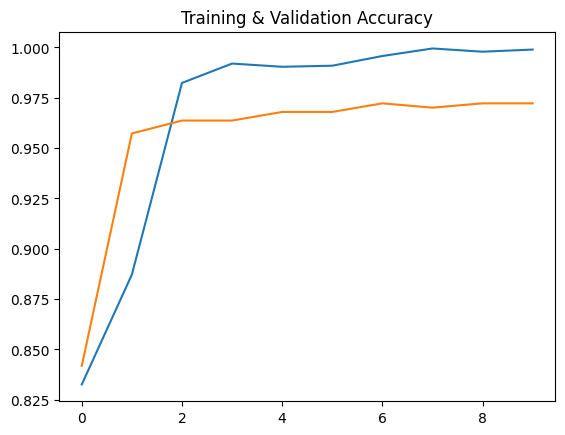

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training & Validation Accuracy')

### Get Recommendation Based on User's Level of Exercise

In [ ]:
# Step 7: Get recommendations based on user's goal
user_goal = "Intermediate"  # Example user input

# Encode the user's goal
encoded_goal = label_encoder.transform([user_goal])[0]

# Get all exercises associated with the user's goal
goal_exercises = df_exercises[df_exercises['BodyPart'] == encoded_goal]

# Group the goal exercises by type and body part
grouped_exercises = goal_exercises.groupby(['Type', 'BodyPart'])

# Store recommended exercises
recommendations = []

# Iterate over each group and select at least 2 exercises
for group, exercises in grouped_exercises:
    type_val, body_part_val = group
    selected_exercises = exercises.sample(n=min(2, len(exercises)))  # Select at most 2 exercises
    recommendations.extend(selected_exercises['Title'].tolist())

# Print the recommendations
print(f"Recommended {user_goal} exercises for Fighter:")
for exercise in recommendations:
    print(exercise)

Recommended Intermediate exercises for Fighter:
Carioca quick step
Lateral hop
UNS Foam Roll Adductor
Band Hip Adductions
Groin and Back Stretch
Lying Bent Leg Groin


### Save and Convert the model into a TFLite model

In [5]:
# Step 8: Convert the model to TFLite
model.save('recommendation_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp4gocm_wa/assets
INFO:tensorflow:Assets written to: /tmp/tmp4gocm_wa/assets
2023-06-13 12:00:09.603862: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-13 12:00:09.603924: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-06-13 12:00:09.604328: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4gocm_wa
2023-06-13 12:00:09.606602: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-06-13 12:00:09.606633: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4gocm_wa
2023-06-13 12:00:09.614164: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-06-13 12:00:09.662232: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmp4gocm_wa
2023-06-13 12:00:09.67

### Save the TFLite model to a file

In [7]:
# Save the TFLite model to a file
with open('recommendation_model.tflite', 'wb') as f:
    f.write(tflite_model)

### Check if the output between models is the same

In [30]:
import tensorflow as tf
import numpy as np

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="recommendation_model.tflite")
interpreter.allocate_tensors()

# Get the input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print(output_details)

# Prepare a sample input
sample_input = np.zeros(input_details[0]['shape'], dtype=np.float32)  # Adjust the shape and data type as per your model's input

# Run the pre-converted model
preconverted_output = model.predict(sample_input)

# Run the TFLite model
interpreter.set_tensor(input_details[0]['index'], sample_input)
interpreter.invoke()
tflite_output = interpreter.get_tensor(output_details[0]['index'])

print("tflite output:",tflite_output)
print("preconvert output:",preconverted_output)

# Compare the outputs
output_equal = np.allclose(preconverted_output, tflite_output, atol=1e-6)
if output_equal:
    print("The TFLite model produces the same output as the pre-converted model.")
else:
    print("The TFLite model does not produce the same output as the pre-converted model.")

[{'name': 'serving_default_dense_input:0', 'index': 0, 'shape': array([   1, 1966], dtype=int32), 'shape_signature': array([  -1, 1966], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 13, 'shape': array([1, 3], dtype=int32), 'shape_signature': array([-1,  3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
1/1 [==============================] - 0s 216ms/step
tflite output: [[0.2125924  0.11313896 0.67426866]]
preconvert output: [[0.2125924  0.11313895 0.67426866]]
The TFLite model produces the same output as the pre-converted model.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4fc1a543-86f4-4a56-bd44-faf0ae2603d5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>